In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import os

plt.rcParams["font.family"] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['CMU Sans Serif']
plt.rcParams['mathtext.default'] = 'regular'
params = {'text.usetex': False, 'mathtext.fontset': 'cm'}
plt.rcParams.update(params)

SMALL_SIZE = 12
MEDIUM_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
scan_prefix = '../data/simulation_gaussian_gfp_out/simulation_gaussian_gfp'

# Parameter scans


In [3]:
def read_params_config(filename):
    df = pd.read_csv(filename, nrows=11)
    return df

def get_params_config(df, param):
    return df.loc[df['name'] == param]

def get_scan_file(search_dir):
    all_files = os.listdir(search_dir) 
    files = []
    for file in all_files:
        if "scan_" in file and ".csv" in file:
            files.append(os.path.join(search_dir ,file))
    return files

def get_scan_file_prefix(prefix):
    suffix_ordered =["_scan_mean_lambda.csv",
                    "_scan_gamma_lambda.csv",
                    "_scan_var_lambda.csv",
                    "_scan_mean_q.csv",
                    "_scan_gamma_q.csv",
                    "_scan_var_q.csv",
                    "_scan_beta.csv",
                    "_scan_var_x.csv",
                    "_scan_var_g.csv",
                    "_scan_var_dx.csv",
                    "_scan_var_dg.csv"]
    files = []
    for suffix in suffix_ordered:
        file = prefix + suffix
        if os.path.isfile(file):   
            files.append(file)
    return files


In [4]:
def read_1dscan(filename):
    tag = "scan_"
    base = filename.split("/")[-1]
    parameter = base[base.find(tag)+len(tag):-4]

    df = pd.read_csv(filename, skiprows=14)    
    return df[[parameter, 'likelihood']], parameter


def plot_1dscans(filenames, cols=3, width=14):
    rows = np.ceil(len(filenames)/cols).astype(int)
    fig, axes = plt.subplots(rows, cols, figsize=(width,0.7*width/cols*rows))
    # fig = plt.figure()
    for i, ax in enumerate(axes.ravel()):
        if i<len(filenames):
            scan, parameter = read_1dscan(filenames[i])

            param_range = scan.to_numpy()[:,0]
            ll = scan.to_numpy()[:,1]

            ax.plot(param_range,ll, label='scan')

            params_config = read_params_config(filenames[i])
            init = get_params_config(params_config, parameter)["init"].values[0]
            init_idx = np.searchsorted(param_range, init)
            ax.axvline(x=init, label='simulation value', ls='--', color='tab:orange')
            ax.axhline(y=ll[init_idx], ls='--', color='tab:orange')

            x_scan_max, y_scan_max = param_range[np.nanargmax(ll)], np.nanmax(ll)

            ax.axvline(x=x_scan_max, label='ll max', ls='--', color='tab:green')
            ax.axhline(y=y_scan_max, ls='--', color='tab:green')


            ax.set_xlabel(parameter)
            ax.set_ylabel('log likelihood')
            ax.ticklabel_format(style='sci', scilimits=(0,1), useOffset=False)
            ax.legend()

        else:
            plt.delaxes(ax)

    plt.tight_layout()
    plot_file = "/".join(filenames[0].split("/")[:-1]) + '/1dscans.pdf'
    plt.savefig(plot_file)
    plt.show()



## 1D parameter scans 


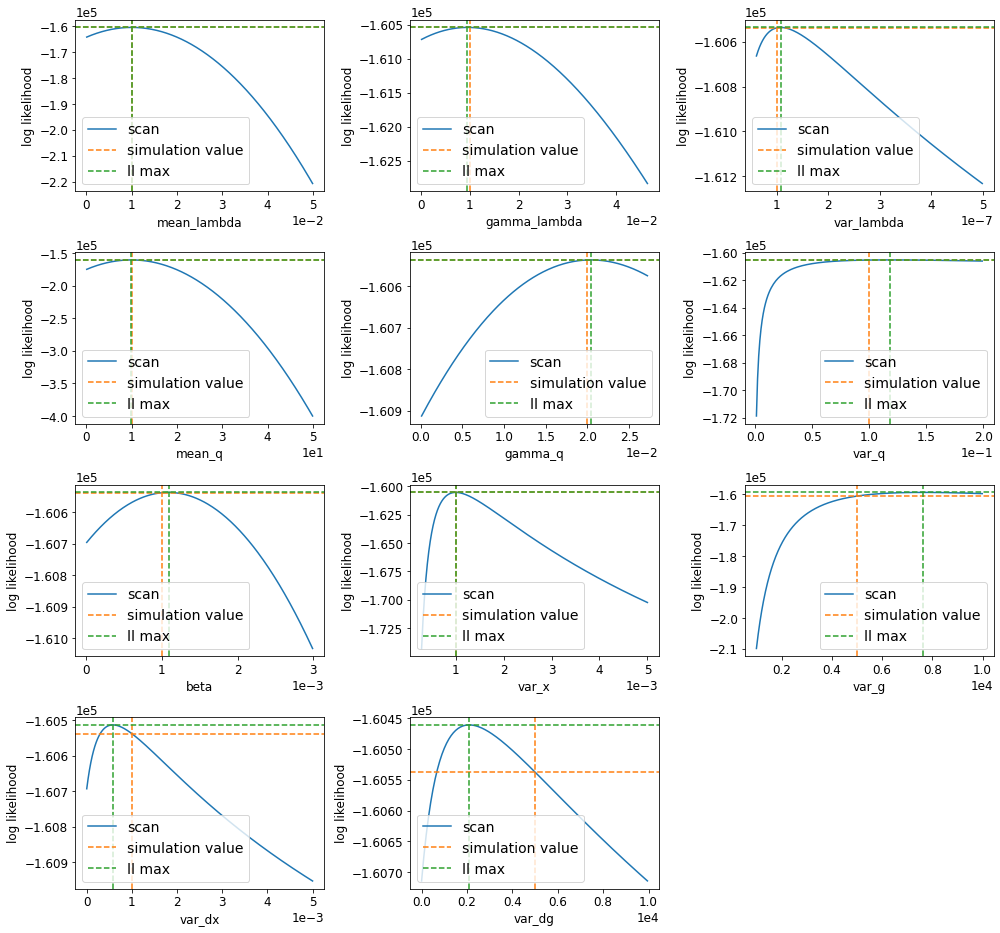

In [5]:
scan_files = get_scan_file_prefix(scan_prefix)
plot_1dscans(scan_files, cols=3)


# Minimization

In [6]:

def read_iteration_process(filename):
    df = pd.read_csv(filename, skiprows=14)    
    return df[["iteration", 'likelihood']]

def plot_minimization(filename):
    mini_data = read_iteration_process(filename)
    fig, ax = plt.subplots(figsize=(10,7))
    iterations = mini_data.to_numpy()[:,0].astype(int)
    ll = mini_data.to_numpy()[:,1]
    ax.plot(iterations, ll)
    ax.scatter(iterations[-1], ll[-1], label="iteration: {:d}, log likelihood: {:.2f}".format(iterations[-1], ll[-1]))
    ax.legend()
    ax.set_xlabel("iterations")
    ax.set_ylabel("log likelihood")
    plt.show()



In [7]:
minimization_file = '../data/simulation_gaussian_gfp_out/simulation_gaussian_gfp_f_b012345678910.csv'
# minimization_file = '../data/simulation_gaussian_gfp_out/simulation_gaussian_gfp_f_b012345678910.csv'
# minimization_file = '../data/simulation_gaussian_gfp_out/simulation_gaussian_gfp_f_b01234578910.csv'

## Iterations 

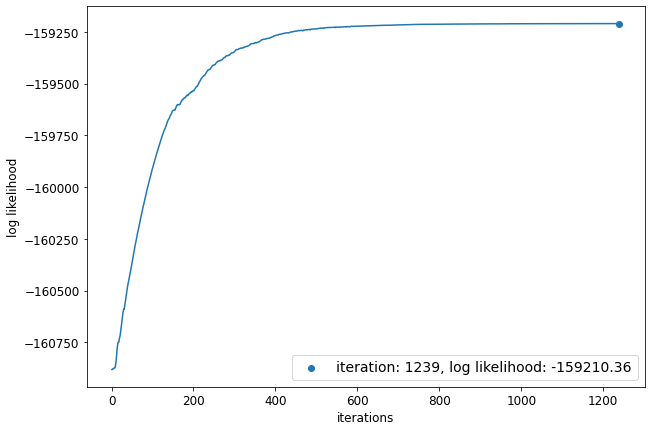

In [8]:
plot_minimization(minimization_file)


## Parameter estimation

In [9]:
def read_minimization(filename, last_n=None):
    df = pd.read_csv(filename, skiprows=14)    
    if last_n != None:
        return df.iloc[[-last_n]]
    return df

def compare_init_final(filename):
    init = read_params_config(filename)[["name", "init"]]
    init=init.set_index("name")

    minimized = read_minimization(filename, 1).transpose()
    reldev = [(init.loc[key].values[0]-minimized.loc[key].values[0])/init.loc[key].values[0] if init.loc[key].values[0]!=0 else None for key in init.index]

    # Table
    comparison = pd.DataFrame({'parameter': init.index, 
                                'simulation': [init.loc[key].values[0] for key in init.index],
                                'minimization': [minimized.loc[key].values[0] for key in init.index],
                                'relative deviation': reldev})


    # plot
    colors = ['tab:orange' if key.startswith('var') else 'tab:blue' for key in init.index]
    fig, ax = plt.subplots(figsize=(10,7))
    plt.title(r"Relative deviation to simulation parameter $(\Theta_i - \Theta_{i, opt})/\Theta_i $")

    x = [xi for xi, ri in zip(np.arange(len(reldev)), reldev) if ri != None]
    reldev = [ri for ri in reldev if ri != None]
    ax.bar(x, reldev, color=colors)

    for i, r in enumerate(reldev):
        if r<0:
            ax.text(x[i] -0.3, r -0.03 , "{:.3f}".format(r), va='center')
        else:
            ax.text(x[i] -0.3, r +0.03 , "{:.3f}".format(r), va='center')


    plt.xticks(np.arange(len(reldev)), init.index[x], rotation=45)
    custom_legend = [Patch(facecolor='tab:orange', label='variances'),
                    Patch(facecolor='tab:blue', label='others')]
    ax.legend(handles=custom_legend, bbox_to_anchor=(1,1), loc="upper left")
    ax.set_ylim([np.min(reldev)-0.1, np.max(reldev) +0.1 ])

    plt.tight_layout()

    plot_file = "/".join(filename.split("/")[:-1]) + '/estim_params.pdf'
    plt.savefig(plot_file)

    plt.show()
    return comparison


## Parameters determined by minimization vs given parameters

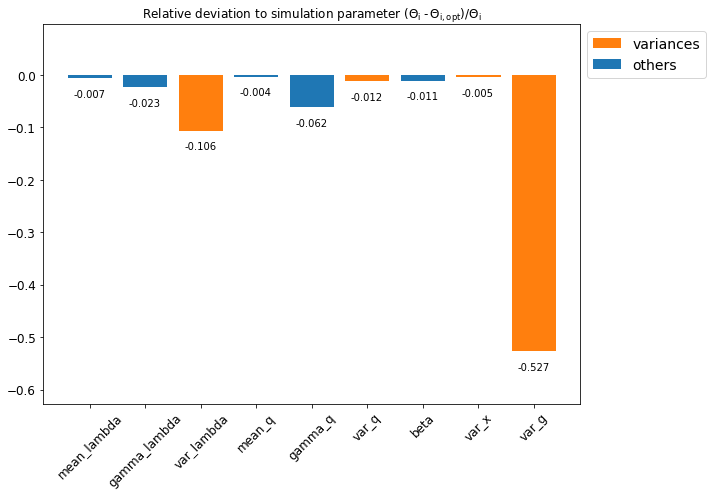

In [10]:
c_tab = compare_init_final(minimization_file)


In [11]:
c_tab

,parameter,simulation,minimization,relative deviation
0,mean_lambda,1.000000e-02,1.006750e-02,-0.006750
1,gamma_lambda,1.000000e-02,1.023120e-02,-0.023120
2,var_lambda,1.000000e-07,1.106130e-07,-0.106130
3,mean_q,1.000000e+01,1.003800e+01,-0.003800
4,gamma_q,2.000000e-02,2.123680e-02,-0.061840
5,var_q,1.000000e-01,1.011880e-01,-0.011880
6,beta,1.000000e-03,1.011090e-03,-0.011090
7,var_x,1.000000e-03,1.004710e-03,-0.004710
8,var_g,5.000000e+03,7.634470e+03,-0.526894
9,var_dx,0.000000e+00,5.665190e-04,NaN


# Time series

In [12]:
infile_dat = '../data/simulation_shared_with_bjoern.csv'
infile_prediction = '../data/simulation_gaussian_gfp_out/simulation_gaussian_gfp_prediction.csv'
infile_backward = '../data/simulation_gaussian_gfp_out/simulation_gaussian_gfp_prediction_backward.csv'
infile_forward = '../data/simulation_gaussian_gfp_out/simulation_gaussian_gfp_prediction_forward.csv'


data_dat = pd.read_csv(infile_dat)

data_prediction = pd.read_csv(infile_prediction, skiprows=13)
data_backward = pd.read_csv(infile_backward, skiprows=13)
data_forward = pd.read_csv(infile_forward, skiprows=13)

len(data_dat), len(data_prediction), len(data_backward), len(data_forward)



(26552, 26552, 26552, 26552)

In [13]:
data_forward.head()

,mean_x,mean_g,mean_l,mean_q,cov_xx,cov_xg,cov_xl,cov_xq,cov_gg,cov_gl,cov_gq,cov_ll,cov_lq,cov_qq
0,0.699530,5889.03,0.010510,19.08150,0.000529,0.000000,0.000000,0.000000,4910.60,0.000000,0.000,0.000017,0.000000,91.34320
1,0.743663,6082.09,0.011366,24.49470,0.000403,0.015811,0.000029,-0.001620,3094.63,0.000302,195.252,0.000015,-0.000031,61.28860
2,0.793974,6090.95,0.012984,14.68120,0.000411,0.022317,0.000041,-0.003373,3059.79,0.001409,210.797,0.000011,-0.000115,31.73710
3,0.818182,6088.84,0.011496,10.02180,0.000429,0.015315,0.000041,-0.003206,2946.15,0.001417,162.145,0.000008,-0.000073,15.62310
4,0.829547,6104.92,0.009498,8.66225,0.000425,0.010979,0.000036,-0.002404,2686.22,0.001369,116.494,0.000005,-0.000020,8.26791


In [14]:
def plot_time_series(data, cols, title=None, n0=0, n=200):
    cmap = plt.cm.tab10

    fig, ax = plt.subplots(figsize=(10,7))
    ax2 = ax.twinx()
    if title !=None:
        plt.title(title)

    time = data['time_min'][n0:n]
    plots = []
    for i, col in enumerate(cols):
        if i%2==0:
            axes = ax
        else:
           axes = ax2

        d = data[col][n0:n]
        plots.append(axes.plot(time, d, 'o', c=cmap(i), label=col)[0])
        axes.plot(time, d, '-', c=cmap(i))

        axes.set_ylabel(col)

    ax.set_xlabel('time (min)')

    ax.legend(plots, [l.get_label() for l in plots])
    plt.show()



def compare_time_series(data, cols, data2, cols2, data_slice, title=None, compared_to=0):
    cmap = plt.cm.tab10
    fig, ax = plt.subplots(figsize=(10,7))

    if title !=None:
        plt.title(title)

    time = data['time_min'][data_slice]
    plots = []

    for i, col in enumerate(cols):
        d = data[col][data_slice]
        plots.append(ax.plot(time, d, 'o', c=cmap(i), label=col)[0])

    for i, col in enumerate(cols2):
        d = data2[col][data_slice]
        plots.append(ax.plot(time, d, '-', c=cmap(compared_to), label=col)[0])

    ax.set_xlabel('time (min)')
    ax.legend(plots, [l.get_label() for l in plots])
    plt.show()


def compare_predictios(predictions, col, data, data_col, data_slice, title=None):
    cmap = plt.cm.tab10
    fig, ax = plt.subplots(figsize=(10,7))
    plots = []

    if title !=None:
        plt.title(title)

    time = data['time_min'][data_slice]

    plots.append(ax.plot(time, predictions[0][col][data_slice], '--', c=cmap(2), label="backward")[0])
    plots.append(ax.plot(time, predictions[1][col][data_slice], '--', c=cmap(1), label="forward")[0])
    plots.append(ax.plot(time, predictions[2][col][data_slice], '-', c=cmap(0), label="backward-forward")[0])

    plots.append(ax.plot(time, data[data_col][data_slice], 'o', c=cmap(0), label="data")[0])

    ax.legend(plots, [l.get_label() for l in plots])

    plt.show()


    

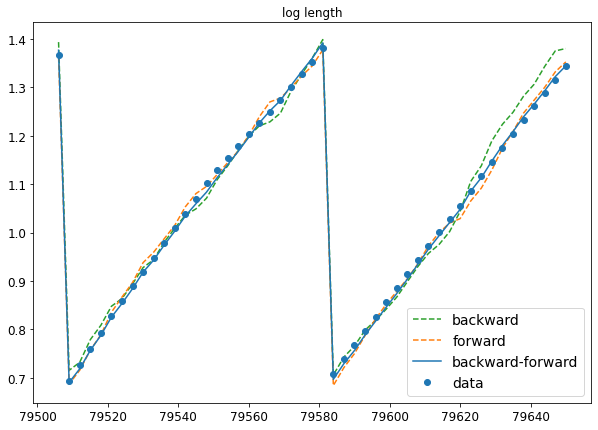

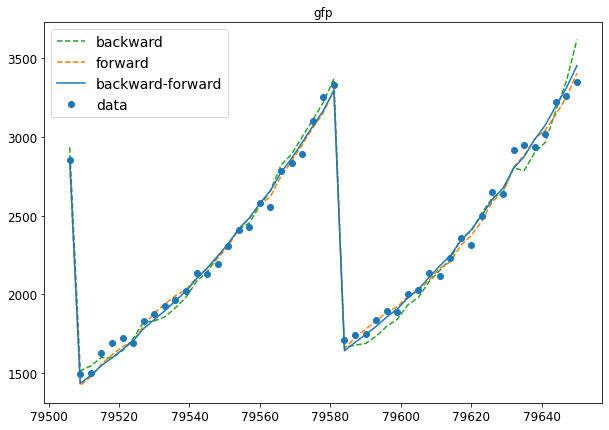

In [15]:
data_slice = slice(-50,-1)
compare_predictios([data_backward, data_forward, data_prediction], 'mean_x', data_dat, 'log_leng_no_noise',data_slice, "log length")
compare_predictios([data_backward, data_forward, data_prediction], 'mean_g', data_dat, 'gfp_no_noise',data_slice, "gfp")


## Backward-forward


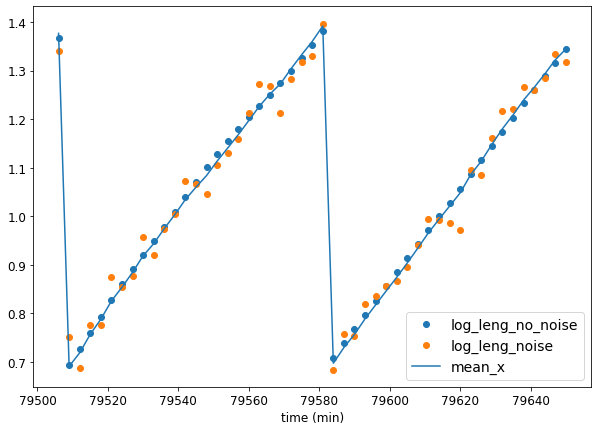

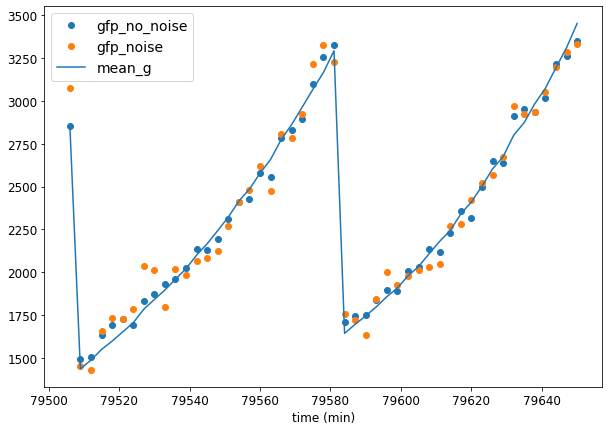

In [16]:

compare_time_series(data_dat, ['log_leng_no_noise','log_leng_noise'], data_prediction, ['mean_x'], data_slice)
compare_time_series(data_dat, ['gfp_no_noise','gfp_noise'], data_prediction, ['mean_g'], data_slice)


## Forward

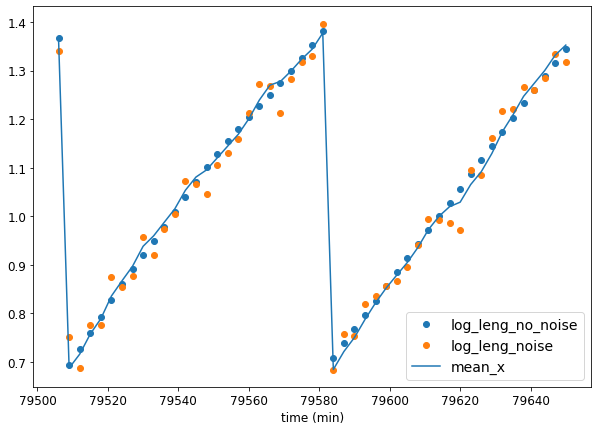

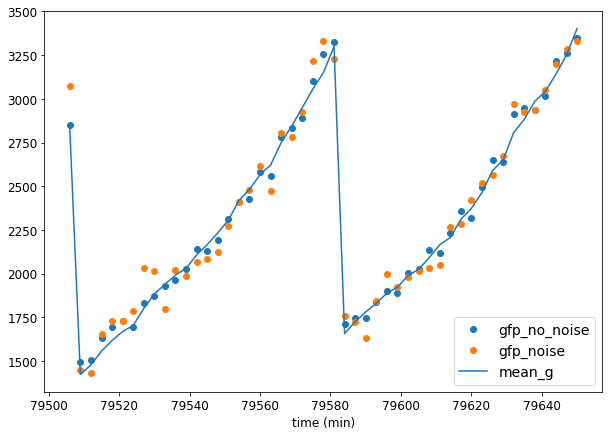

In [17]:

compare_time_series(data_dat, ['log_leng_no_noise','log_leng_noise'], data_forward, ['mean_x'], data_slice)
compare_time_series(data_dat, ['gfp_no_noise','gfp_noise'], data_forward, ['mean_g'], data_slice)

## Backward

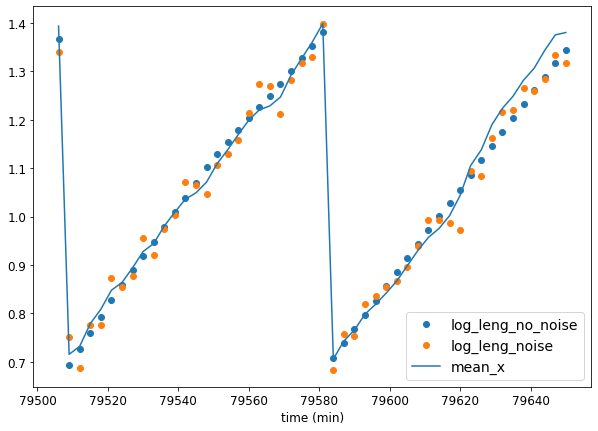

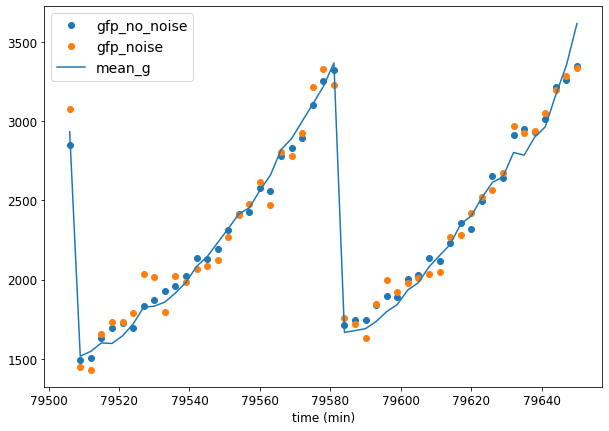

In [18]:

compare_time_series(data_dat, ['log_leng_no_noise','log_leng_noise'], data_backward, ['mean_x'], data_slice)
compare_time_series(data_dat, ['gfp_no_noise','gfp_noise'], data_backward, ['mean_g'], data_slice)



## Correlation

In [19]:
def corr_window(data1, data2, win_size):
    corr = []
    for i in np.arange(0, len(data1) - win_size, int(win_size/100)):
        d1 = data1[i:i+win_size]
        d2 = data2[i:i+win_size]
        corr.append(np.corrcoef(d1, d2)[0,1])
    return corr, np.corrcoef(data1, data2)[0,1]

def plot_corr(data1, data2, win_size=10):
    corr, tot_corr = corr_window(data1, data2, win_size)
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(corr)
    ax.axhline(y=tot_corr, color = "tab:orange", ls="--", label="{:.3f}".format(tot_corr))
    plt.legend()
    plt.show()



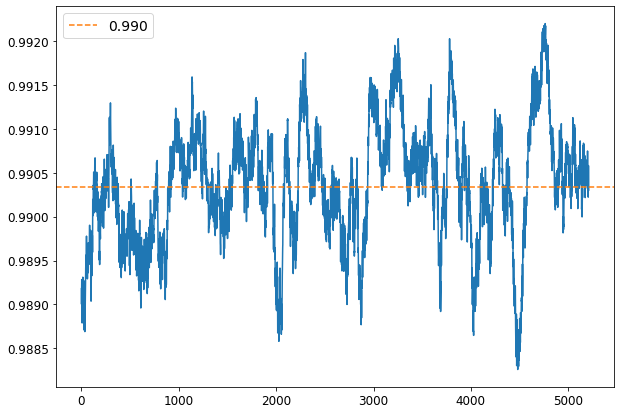

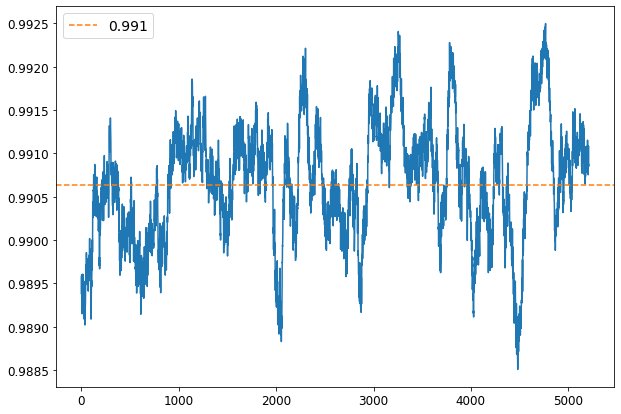

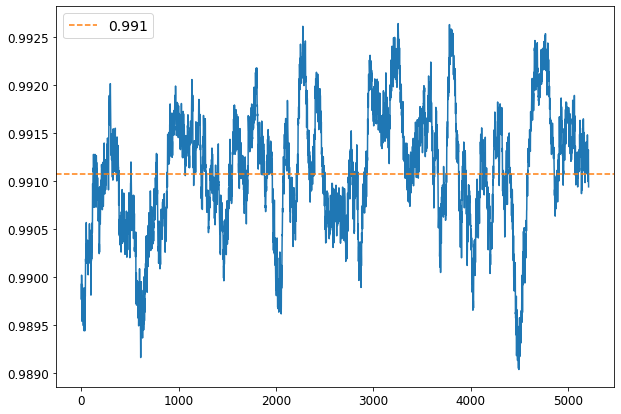

In [20]:
corr = plot_corr(data_dat['log_leng_noise'].to_numpy(), data_prediction['mean_x'].to_numpy(), win_size=500)
corr = plot_corr(data_dat['log_leng_noise'].to_numpy(), data_forward['mean_x'].to_numpy(), win_size=500)
corr = plot_corr(data_dat['log_leng_noise'].to_numpy(), data_backward['mean_x'].to_numpy(), win_size=500)

##  Total error

In [21]:
def total_sqerror(data1, data2):
    err = []
    for i, _ in enumerate(data1):
        err.append(np.power(data1[i] - data2[i], 2))

    return np.sum(err)

In [22]:
print(total_sqerror(data_dat['log_leng_noise'].to_numpy(), data_prediction['mean_x'].to_numpy()))
print(total_sqerror(data_dat['log_leng_noise'].to_numpy(), data_backward['mean_x'].to_numpy()))
print(total_sqerror(data_dat['log_leng_noise'].to_numpy(), data_forward['mean_x'].to_numpy()))

22.025398559210615
20.084752351721946
21.09198397633243


,mean_x,mean_g,mean_l,mean_q,cov_xx,cov_xg,cov_xl,cov_xq,cov_gg,cov_gl,cov_gq,cov_ll,cov_lq,cov_qq
0,0.699530,5889.03,0.010510,19.08150,0.000529,0.000000,0.000000,0.000000,4910.60,0.000000,0.000,0.000017,0.000000,91.34320
1,0.743663,6082.09,0.011366,24.49470,0.000403,0.015811,0.000029,-0.001620,3094.63,0.000302,195.252,0.000015,-0.000031,61.28860
2,0.793974,6090.95,0.012984,14.68120,0.000411,0.022317,0.000041,-0.003373,3059.79,0.001409,210.797,0.000011,-0.000115,31.73710
3,0.818182,6088.84,0.011496,10.02180,0.000429,0.015315,0.000041,-0.003206,2946.15,0.001417,162.145,0.000008,-0.000073,15.62310
4,0.829547,6104.92,0.009498,8.66225,0.000425,0.010979,0.000036,-0.002404,2686.22,0.001369,116.494,0.000005,-0.000020,8.26791
